In [1]:
# making connection with kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# downloading the dataset
! kaggle datasets download -d agrigorev/clothing-dataset-full

100% 6.50G/6.50G [01:30<00:00, 121MB/s]
100% 6.50G/6.50G [01:31<00:00, 76.6MB/s]


In [3]:
# unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('/content/clothing-dataset-full.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [49]:
# Importing the Libraries

import random
import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Activation,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [5]:
# Defining the hyper parameters

TRAINING_DIR = '/content/images_compressed'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMAGE_SIZE = (224,224)
EPOCHS = 100

In [6]:
# displaying the type of files present in the training directory

file_names = os.listdir(TRAINING_DIR)
file_names[:10]


['02c1ab85-da02-4fbd-a8b8-a115de4e0c53.jpg',
 '2884d941-ccc9-4eac-b7d7-b9996126a9c8.jpg',
 'ecf5dd44-9c10-4576-adfa-2850e803ad39.jpg',
 '2acc95a9-ac27-41e6-8061-9b43849db240.jpg',
 '01f52917-7e92-4c47-8979-1ab9a41c96a8.jpg',
 '16d5fbeb-bc4b-43ab-9bc6-89a385d42dd3.jpg',
 '672b0d76-2277-4edf-8903-51cd6646b139.jpg',
 'c6d71611-6bae-4645-8a93-959973e05f8b.jpg',
 '79ac5fa4-8083-4f22-be14-cebf1dcf03a1.jpg',
 '3901a67e-e2da-483f-89ac-e0472b33e5a9.jpg']

In [7]:
# reading the csv file

data = pd.read_csv('/content/images.csv')
data.head()

image  sender_id     label   kids
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False

In [8]:
# adding .jpg extension to the images

data['image'] = data['image'] + '.jpg'
data_1 = data[['image','label']]
data_1.head()

image     label
0  4285fab0-751a-4b74-8e9b-43af05deee22.jpg  Not sure
1  ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg   T-Shirt
2  00627a3f-0477-401c-95eb-92642cbe078d.jpg  Not sure
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg   T-Shirt
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg     Shoes

In [9]:
# displaying images with the jpg extension

data_1['image']

0       4285fab0-751a-4b74-8e9b-43af05deee22.jpg
1       ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg
2       00627a3f-0477-401c-95eb-92642cbe078d.jpg
3       ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg
4       3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg
                          ...                   
5398    dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
5399    befa14be-8140-4faf-8061-1039947e329d.jpg
5400    5379356a-40ee-4890-b416-2336a7d84061.jpg
5401    65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg
5402    32b99302-cec7-4dec-adfa-3d4029674209.jpg
Name: image, Length: 5403, dtype: object

In [10]:
# Checking for the corrupted images

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(TRAINING_DIR).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/content/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg
/content/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
/content/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
/content/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
/content/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
/content/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg


In [11]:
# creating a list of the corrupted images

corrupted = ['b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
             '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
             'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
            'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
             '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg',
             '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

In [12]:
# removing the corrupted images

data_1 = data_1.drop(data_1[data_1['image'].isin(corrupted)].index, axis=0)

In [13]:
#visualizing the categories of images available

fig = px.bar(data_1['label'].value_counts())
fig.show()

In [14]:
# displaying the total number of categories available and the type of items

category_names = list(data_1['label'].unique())
print(len(category_names))
category_names

20


['Not sure',
 'T-Shirt',
 'Shoes',
 'Shorts',
 'Shirt',
 'Pants',
 'Skirt',
 'Other',
 'Top',
 'Outwear',
 'Dress',
 'Body',
 'Longsleeve',
 'Undershirt',
 'Hat',
 'Polo',
 'Blouse',
 'Hoodie',
 'Skip',
 'Blazer']

In [15]:
# dispalying number of items of each category available

category_dict = dict(zip(category_names, range(len(category_names))))
category_dict

{'Not sure': 0,
 'T-Shirt': 1,
 'Shoes': 2,
 'Shorts': 3,
 'Shirt': 4,
 'Pants': 5,
 'Skirt': 6,
 'Other': 7,
 'Top': 8,
 'Outwear': 9,
 'Dress': 10,
 'Body': 11,
 'Longsleeve': 12,
 'Undershirt': 13,
 'Hat': 14,
 'Polo': 15,
 'Blouse': 16,
 'Hoodie': 17,
 'Skip': 18,
 'Blazer': 19}

In [16]:
# categories that can be removed

labels_to_remove = ['Skip', 'Not sure', 'Other','Blouse']

In [17]:
# removing the above mentioned categories

data_1 = data_1[~data_1['label'].isin(labels_to_remove)]

In [18]:
# visualizing the categories of images available after removing above mentioned categories

fig = px.bar(data_1['label'].value_counts())
fig.show()

In [19]:
# creating the training dataset

y_train = data_1['label']

In [20]:
# creating function to dispaly the random trainiing images

def show_random_training_image():
    random_index = random.choice(data_1.index)
    img_path = data_1['image'][random_index]
    label = data_1['label'][random_index]
    complete_path = TRAINING_DIR + '/' + img_path
    image = mpimg.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

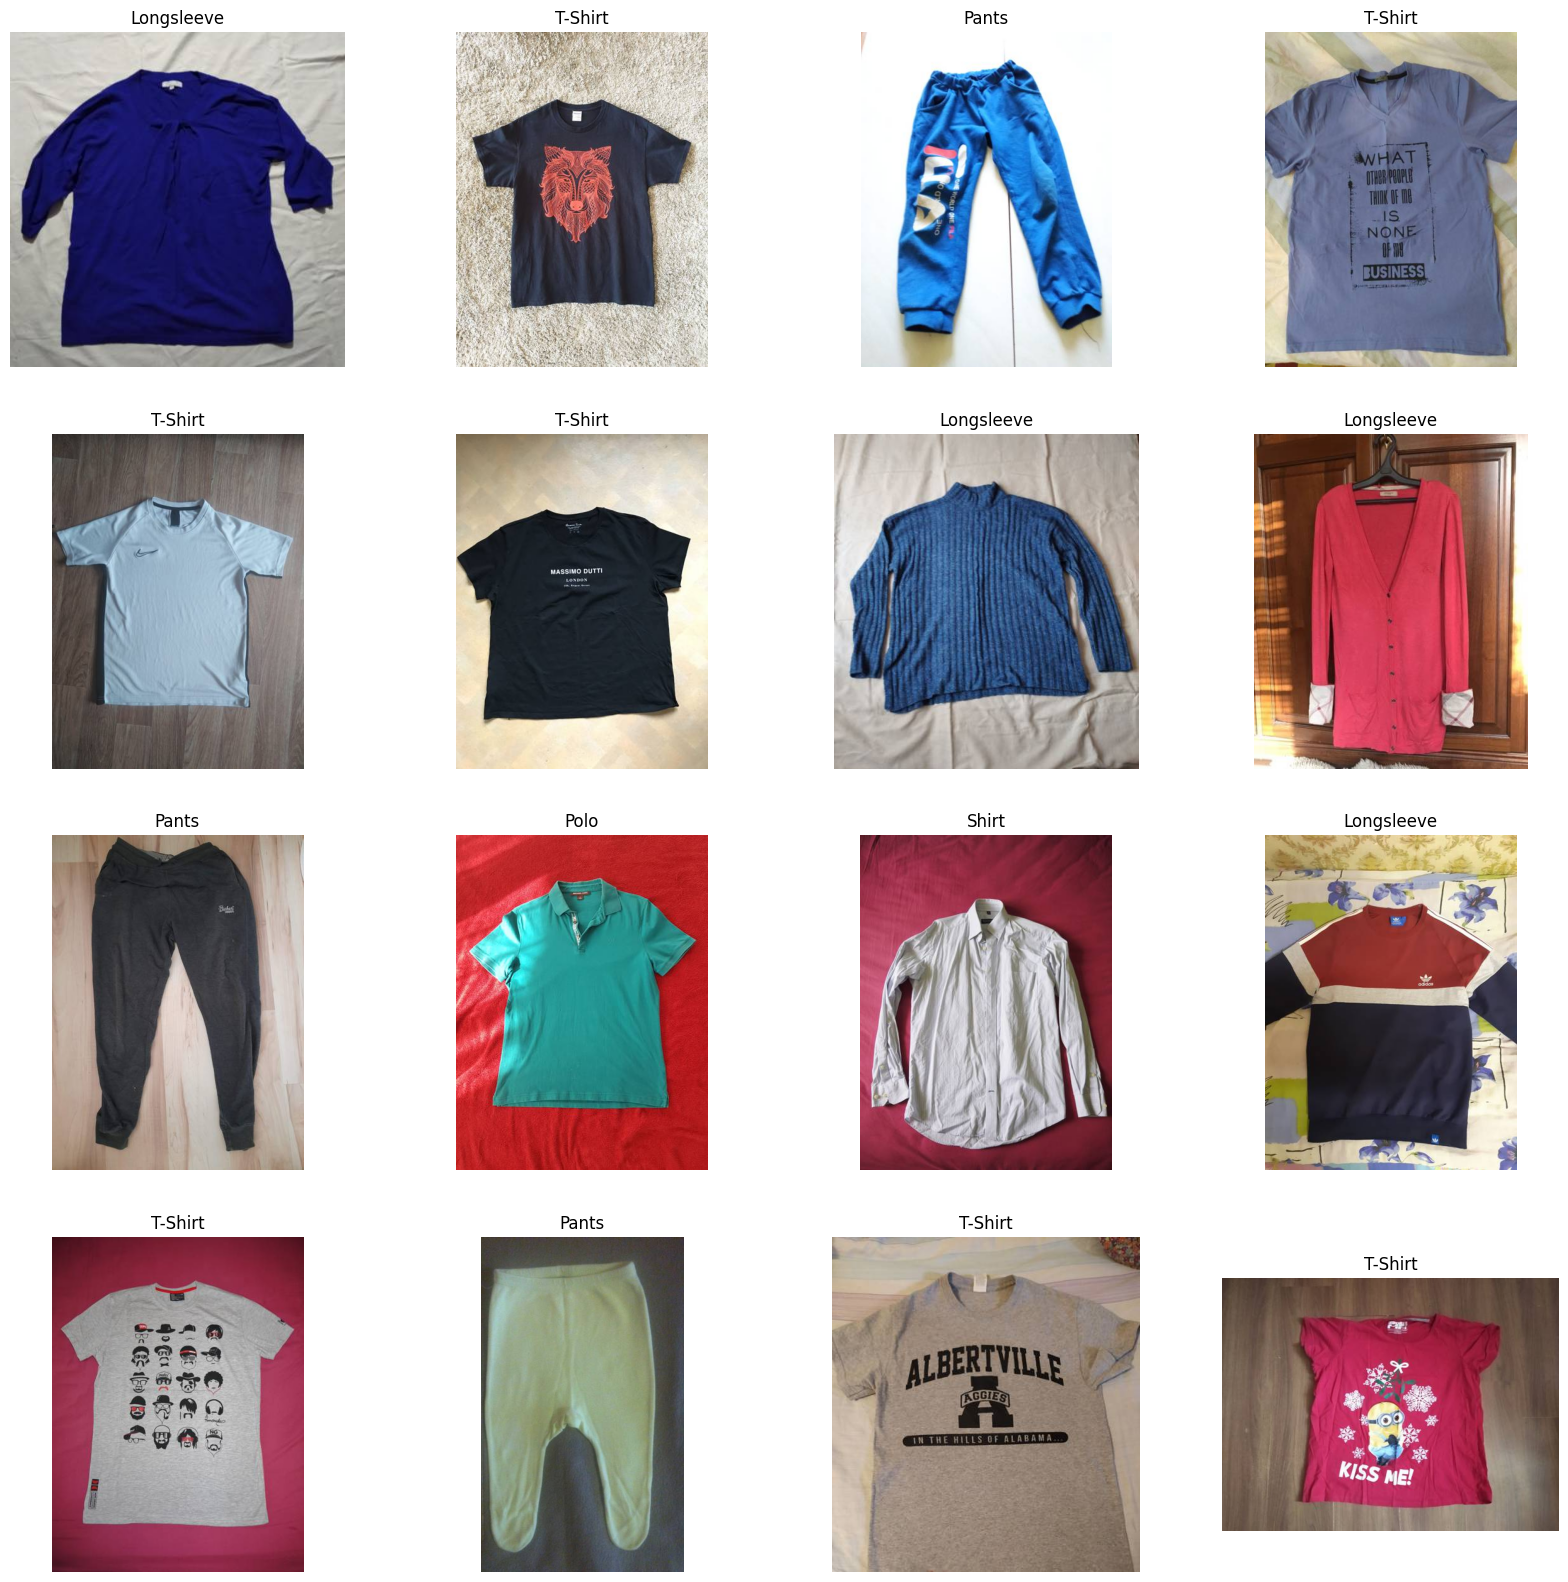

In [21]:
# displaying the random training images

plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    show_random_training_image()

In [22]:
# data augmentation

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)


validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 4566 validated image filenames belonging to 16 classes.
Found 507 validated image filenames belonging to 16 classes.


In [23]:
# importing the pre trained model MobileNetV2


from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

conv_base = MobileNetV2(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [25]:
# creating the model using the pre trained model

model = Sequential()

model.add(conv_base)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16,activation='Softmax'))

In [26]:
conv_base.trainable = False

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1280)        5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [28]:
learn_rate = LEARNING_RATE

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb = ModelCheckpoint('mobilenetv2.h5', save_best_only=True)

In [29]:
# compiling the model

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [30]:
# training the model

history = model.fit(train_generator, epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[es, cb])

Epoch 1/100
143/143 [==============================] - 92s 576ms/step - loss: 2.7282 - accuracy: 0.4306 - val_loss: 2.0993 - val_accuracy: 0.4596
Epoch 2/100
143/143 [==============================] - 74s 522ms/step - loss: 1.8407 - accuracy: 0.5028 - val_loss: 1.8548 - val_accuracy: 0.4931
Epoch 3/100
143/143 [==============================] - 73s 513ms/step - loss: 1.6514 - accuracy: 0.5269 - val_loss: 1.7636 - val_accuracy: 0.5168
Epoch 4/100
143/143 [==============================] - 75s 526ms/step - loss: 1.5491 - accuracy: 0.5414 - val_loss: 1.7369 - val_accuracy: 0.5247
Epoch 5/100
143/143 [==============================] - 73s 510ms/step - loss: 1.4570 - accuracy: 0.5637 - val_loss: 1.6702 - val_accuracy: 0.5049
Epoch 6/100
143/143 [==============================] - 73s 511ms/step - loss: 1.4109 - accuracy: 0.5692 - val_loss: 1.5942 - val_accuracy: 0.5404
Epoch 7/100
143/143 [==============================] - 74s 518ms/step - loss: 1.3785 - accuracy: 0.5782 - val_loss: 1.6412 -

In [31]:
# evaluating the loss and accuracy if the model

loss, accuracy = model.evaluate(validation_generator, verbose=0)

In [32]:
# displaying the loss and accuracy

print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 1.41 and Accuracy is 60.160000000000004%


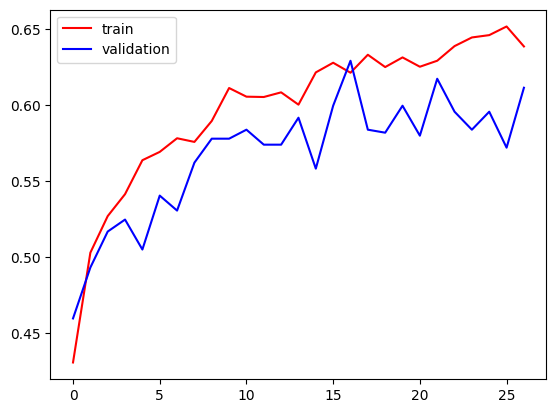

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

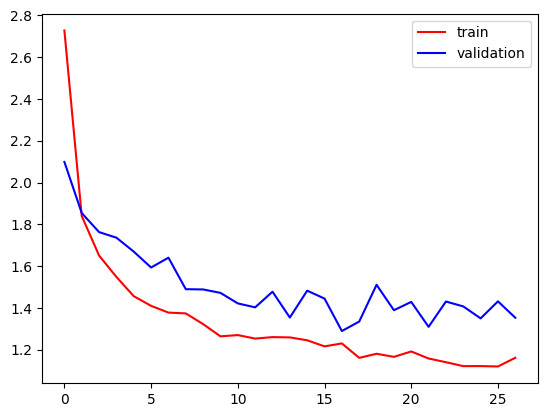

In [34]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [35]:
classes = list(train_generator.class_indices.keys())

In [36]:
def predict_val_image(index):
    predictions =  model.predict(val_images, verbose=0)[index]
    true_label = classes[val_labels[index].argmax()]
    predicted_label = classes[predictions.argmax()]

    if(true_label== predicted_label):
        color = 'green'
    else:
        color = 'red'

    plt.title(f"True : {true_label} Predicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')

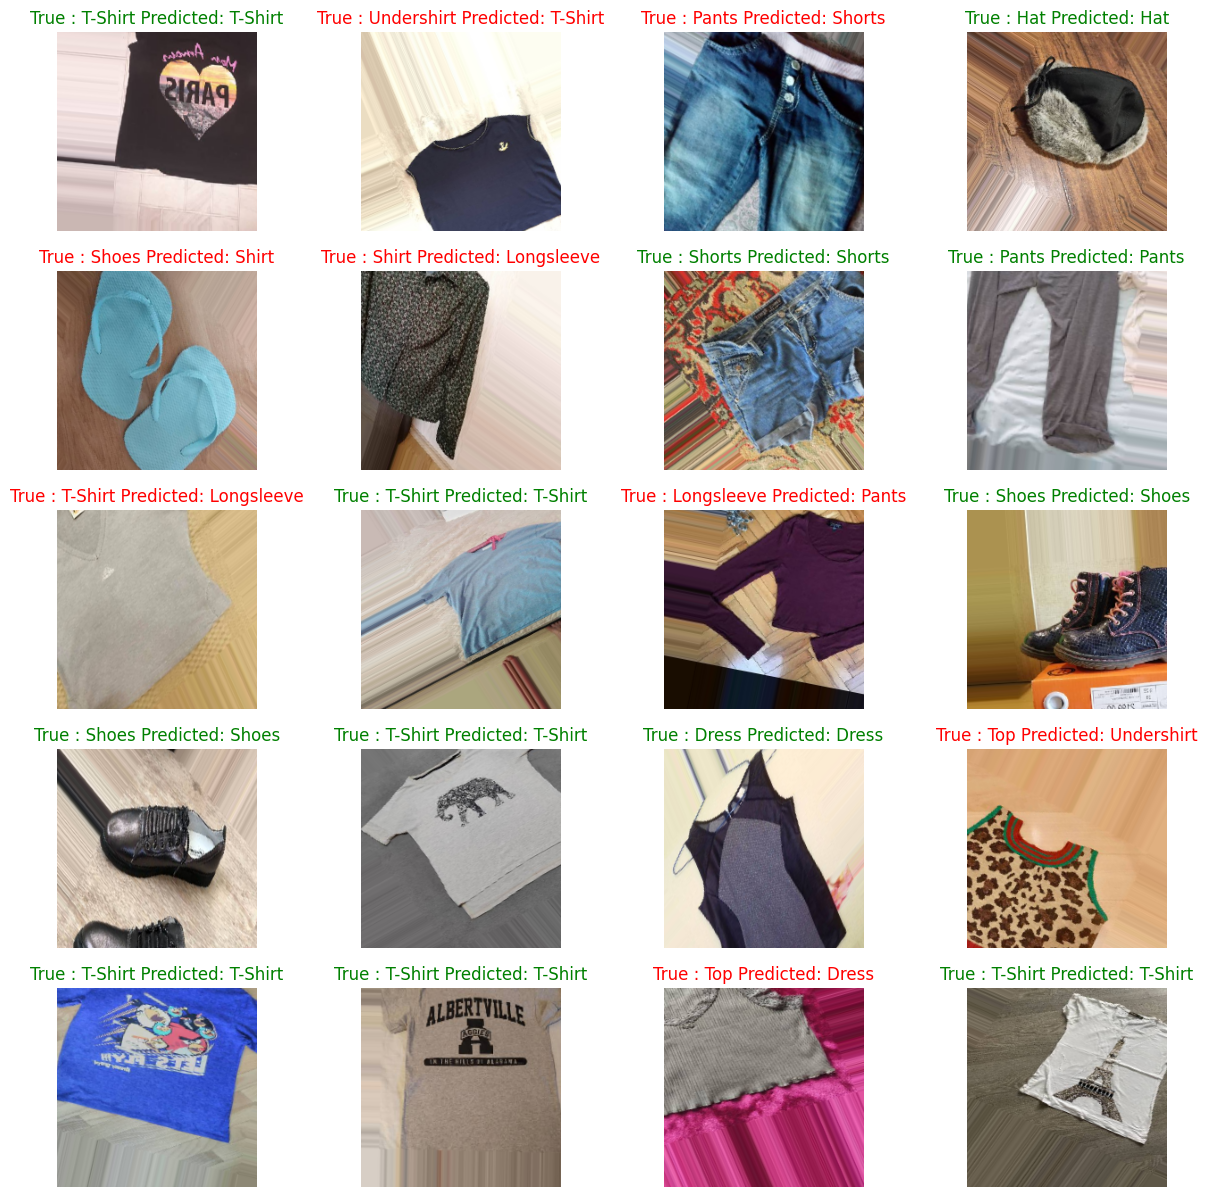

In [38]:
# prediction on validation images

val_images, val_labels = validation_generator.next()
plt.figure(figsize=(15, 15))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i)

In [45]:
# prediction on unseen images

custom_dir = '/content/images_original'

In [46]:
custom_paths = []
for image in os.listdir(custom_dir):
        custom_paths.append(custom_dir+'/'+image)

In [50]:
def predict_random_image():
    path = random.choice(custom_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

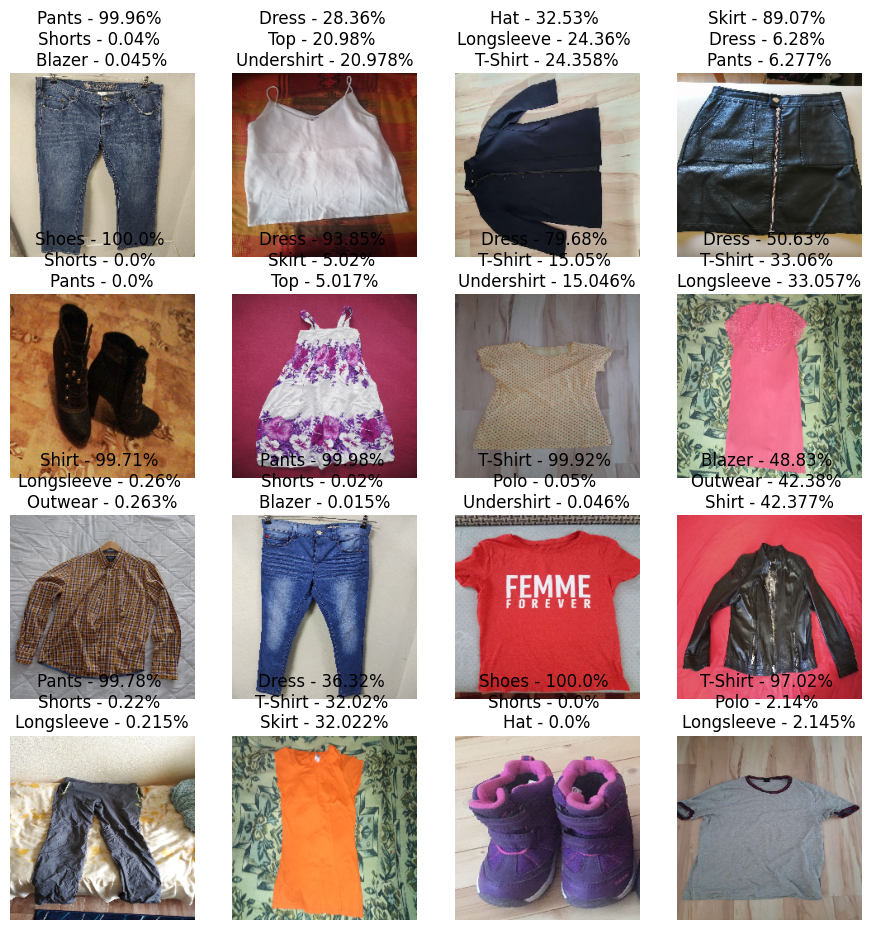

In [54]:
#Top 3 predictions on unseen images

plt.figure(figsize=(11, 11))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_image()